# Mango Leaf Disease Classification - 10 Steps Pipeline 

---
## STEP 1. Problem Understanding

### Mô tả bài toán
Xây dựng một mô hình **Deep Learning** nhằm tự động nhận diện các bệnh và tổn thương trên lá cây xoài dựa trên ảnh RGB thu thập từ thực tế.

| Thuộc tính | Mô tả |
|------------|-------|
| **Loại bài toán** | Supervised Learning - Classification |
| **Input** | Ảnh RGB của lá xoài (224×224 pixels) |
| **Output** | Một trong 9 lớp bệnh hoặc trạng thái lá khỏe |

### Mục tiêu nghiên cứu
- Xây dựng **pipeline hoàn chỉnh** từ dữ liệu → mô hình → đánh giá
- So sánh hiệu quả giữa các mô hình Deep Learning** (EfficientNet, MobileNet, ResNet, VGG, DenseNet, Inception, ...)


In [3]:
# Cài đặt các thư viện cần thiết 
!pip install tensorflow numpy pandas matplotlib seaborn pillow scikit-learn tqdm -q


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
# Import các thư viện cần thiết
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.applications import (
    EfficientNetB0, MobileNetV2, ResNet50, 
    VGG16, DenseNet121, InceptionV3
)
from tensorflow.keras import layers, models, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Cấu hình GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {gpus}")

# Set AUTOTUNE cho tf.data pipeline
AUTOTUNE = tf.data.AUTOTUNE

2025-12-30 23:05:45.113537: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-30 23:05:45.661754: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-30 23:05:47.865194: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-30 23:05:47.865194: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TensorFlow version: 2.20.0
GPU Available: []


E0000 00:00:1767110748.661609  127831 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1767110748.670386  127831 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
# Cấu hình
DATA_DIR = "./MangoLeaf_Dataset"

---
## STEP 2. Data Understanding

Kiểm tra:
- Missing Values?
- Outliers (Noise)?
- Inconsistent data?
- Imbalanced classes?
- Skewness?

In [8]:
# Thống kê số lượng ảnh theo từng lớp
classes = sorted(os.listdir(DATA_DIR))
stats = []
for c in classes:
    class_path = os.path.join(DATA_DIR, c)
    num_images = len(os.listdir(class_path))
    stats.append({"Class": c, "Num_Images": num_images})

df_stats = pd.DataFrame(stats)
print("=" * 50)
print("THỐNG KÊ DATASET")
print("=" * 50)
print(df_stats.to_string(index=False))
print(f"\nTổng số ảnh: {df_stats['Num_Images'].sum()}")
print(f"Số lớp: {len(classes)}")
print(f"\nMissing Values: Không có (tất cả ảnh đều tồn tại)")
print(f"Imbalanced: {'Có' if df_stats['Num_Images'].std() > 30 else 'Không'}")

THỐNG KÊ DATASET
           Class  Num_Images
     Anthracnose         390
Bacterial_Canker         400
  Bacterial_Spot         391
  Cutting_Weevil         400
        Die_Back         396
      Gall_Midge         400
         Healthy         400
  Powdery_Mildew         400
     Sooty_Mould         400

Tổng số ảnh: 3577
Số lớp: 9

Missing Values: Không có (tất cả ảnh đều tồn tại)
Imbalanced: Không


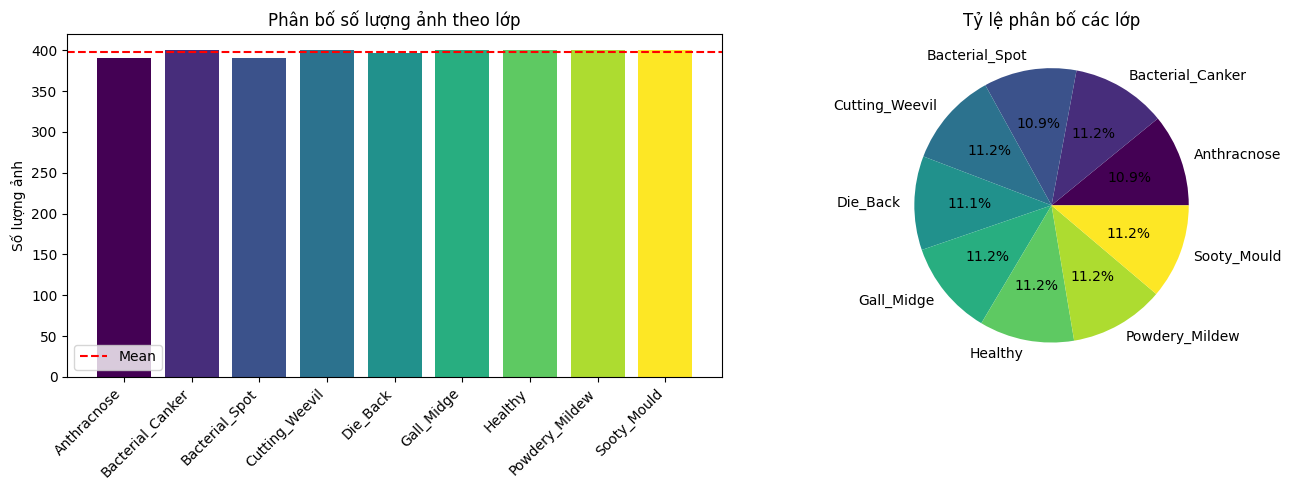

In [9]:
# Visualize phân bố lớp
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
axes[0].bar(df_stats["Class"], df_stats["Num_Images"], color=colors)
axes[0].set_xticklabels(df_stats["Class"], rotation=45, ha='right')
axes[0].set_ylabel("Số lượng ảnh")
axes[0].set_title("Phân bố số lượng ảnh theo lớp")
axes[0].axhline(y=df_stats['Num_Images'].mean(), color='r', linestyle='--', label='Mean')
axes[0].legend()

# Pie chart
axes[1].pie(df_stats["Num_Images"], labels=df_stats["Class"], autopct='%1.1f%%', colors=colors)
axes[1].set_title("Tỷ lệ phân bố các lớp")

plt.tight_layout()
plt.show()

---
## STEP 3. Feature Understanding (EDA)

- **Univariate Analysis:** Phân tích từng lớp riêng lẻ
- **Bivariate Analysis:** So sánh giữa các lớp
- **Multivariate Analysis:** Phân tích đa chiều (RGB channels)

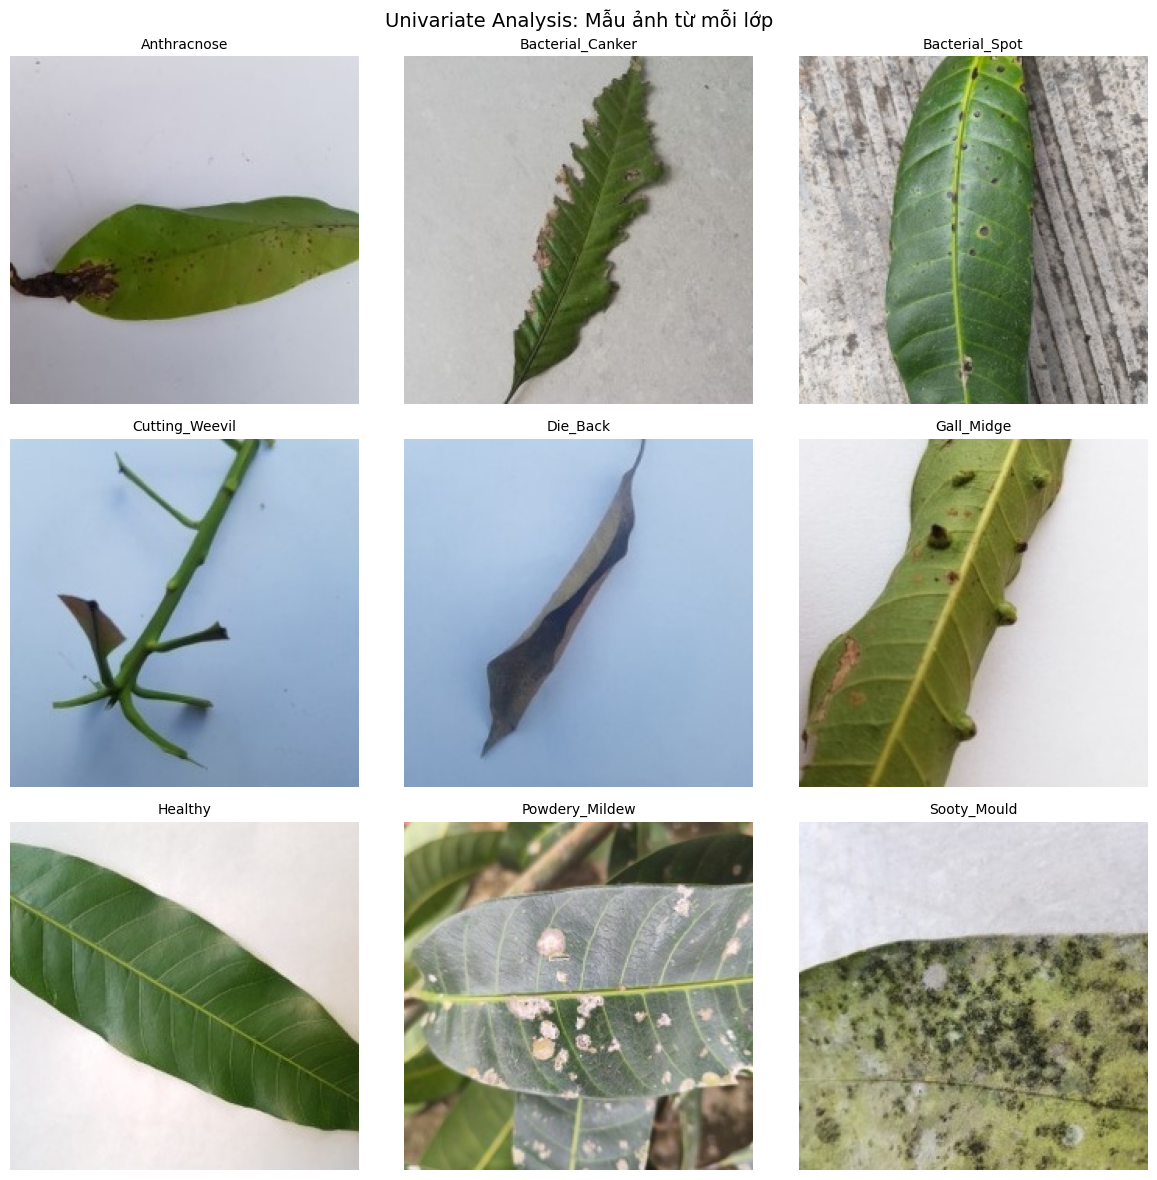

In [10]:
# Univariate: Hiển thị mẫu ảnh từ mỗi lớp
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for idx, c in enumerate(classes):
    class_path = os.path.join(DATA_DIR, c)
    img_name = os.listdir(class_path)[0]
    img = Image.open(os.path.join(class_path, img_name))
    axes[idx].imshow(img)
    axes[idx].set_title(c, fontsize=10)
    axes[idx].axis('off')

plt.suptitle("Univariate Analysis: Mẫu ảnh từ mỗi lớp", fontsize=14)
plt.tight_layout()
plt.show()

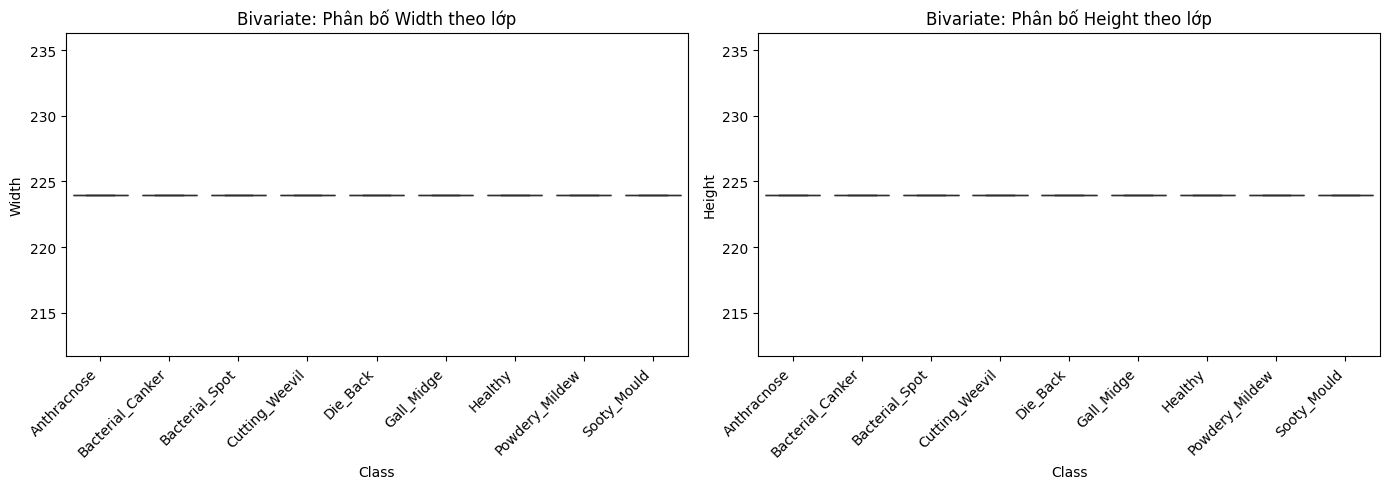

In [11]:
# Bivariate: Phân tích kích thước ảnh theo lớp
size_data = []
for c in classes:
    class_path = os.path.join(DATA_DIR, c)
    for img_name in os.listdir(class_path)[:30]:  # Lấy mẫu 30 ảnh/lớp
        img = Image.open(os.path.join(class_path, img_name))
        w, h = img.size
        size_data.append({"Class": c, "Width": w, "Height": h})

df_size = pd.DataFrame(size_data)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=df_size, x="Class", y="Width", ax=axes[0], palette="viridis")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title("Bivariate: Phân bố Width theo lớp")

sns.boxplot(data=df_size, x="Class", y="Height", ax=axes[1], palette="viridis")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title("Bivariate: Phân bố Height theo lớp")

plt.tight_layout()
plt.show()

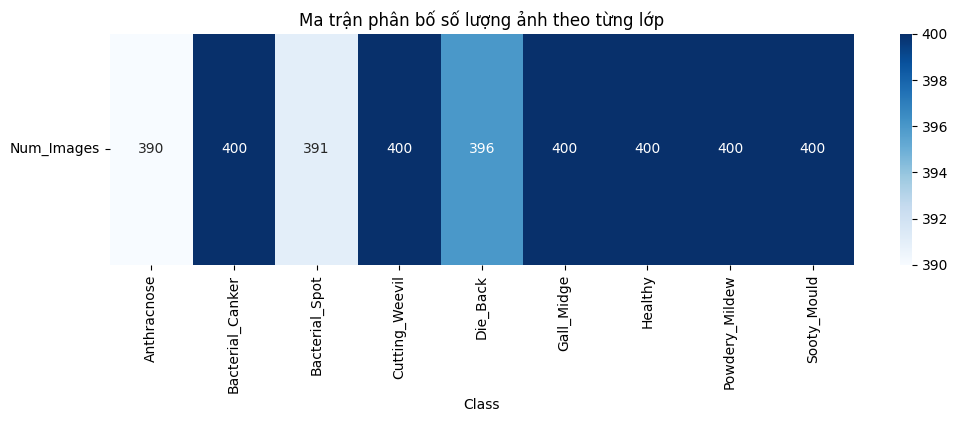

In [ ]:
# Biểu đồ phân bố số lượng ảnh theo lớp
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = plt.cm.viridis(np.linspace(0, 1, len(df_stats)))
bars = axes[0].bar(df_stats['Class'], df_stats['Num_Images'], color=colors)
axes[0].set_xticklabels(df_stats['Class'], rotation=45, ha='right')
axes[0].set_ylabel('Số lượng ảnh')
axes[0].set_title('Phân bố số lượng ảnh theo lớp')
axes[0].axhline(y=df_stats['Num_Images'].mean(), color='r', linestyle='--', label='Trung bình')

# Thêm số liệu trên bar
for bar in bars:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                 int(bar.get_height()), ha='center', fontsize=9)
axes[0].legend()

# Pie chart
axes[1].pie(df_stats['Num_Images'], labels=df_stats['Class'], autopct='%1.1f%%', colors=colors)
axes[1].set_title('Tỷ lệ phân bố các lớp')

plt.tight_layout()
plt.show()

# Đánh giá cân bằng
print(f"\n📊 Min: {df_stats['Num_Images'].min()} | Max: {df_stats['Num_Images'].max()} | Mean: {df_stats['Num_Images'].mean():.0f}")

In [ ]:
# Phân bố kích thước ảnh (Width và Height)
widths, heights = [], []

for cls in classes:
    imgs = os.listdir(os.path.join(DATA_DIR, cls))[:30]
    for img_name in imgs:
        img = Image.open(os.path.join(DATA_DIR, cls, img_name))
        w, h = img.size
        widths.append(w)
        heights.append(h)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(widths, bins=20)
plt.title("Phân bố chiều rộng ảnh")

plt.subplot(1,2,2)
plt.hist(heights, bins=20)
plt.title("Phân bố chiều cao ảnh")
plt.show()


---
## STEP 4. Feature Engineering

- **Skewness/Outlier Handling:** Class weights cho imbalanced data
- **Feature Transformation:** Resize về 224x224
- **Feature Scaling:** Normalize [0,1]
- **Data Augmentation:** Rotation, Flip, Zoom, Shift